In [2]:
import pandas as pd
import os

DATA_PATH = os.path.abspath('../data')

# Load CSV file
def load_csv(filename):
    path = os.path.join(DATA_PATH, filename)
    return pd.read_csv(path)


# Clean up original csv
def clean_csv(df):
    print(f"original rows: {len(df)}")

    df = df.dropna()
    print(f"rows after deleting null: {len(df)}")

    df = df.drop_duplicates()
    print(f"rows after deleting duplicates: {len(df)}")

    return df


df_student_vle = load_csv("studentVle.csv")
df_student_reg = load_csv("studentRegistration.csv")
df_student_info = load_csv("studentInfo.csv")

# Fill 0 or unknown for fields that can cause false deletion
df_student_vle['sum_click'] = df_student_vle['sum_click'].fillna(0)
df_student_reg['date_unregistration'] = df_student_reg['date_unregistration'].fillna(0)

cat_cols = ['region', 'gender', 'disability',
            'highest_education', 'imd_band', 'age_band']
df_student_info[cat_cols] = df_student_info[cat_cols].fillna('Not_Provided')

num_cols = ['num_of_prev_attempts', 'studied_credits']
df_student_info[num_cols] = df_student_info[num_cols].fillna(0)

clean_csv(df_student_vle)
clean_csv(df_student_reg)
clean_csv(df_student_info)

df_student_vle = df_student_vle[[
    'id_student', 'code_module', 'code_presentation', 'sum_click']]
df_student_reg = df_student_reg[[
    'id_student', 'code_module', 'code_presentation', 'date_registration']]
clicks_per_student = df_student_vle.groupby(
    ['id_student', 'code_module', 'code_presentation'], as_index=False)['sum_click'].sum()
print(f' click per student:\n{clicks_per_student.head()}')
print(f'student vle: \n{df_student_vle.head()}')
print(f'student reg: \n{df_student_reg.head()} ')
print(f'student info: \n{df_student_info.head()} ')

# Merge csv files
df = pd.merge(df_student_info, clicks_per_student, on=[
              'id_student', 'code_module', 'code_presentation'], how='left')
df = pd.merge(df, df_student_reg, on=[
              'id_student', 'code_module', 'code_presentation'], how='left')

# Fill in sum_click if sum_click is NAH
df['sum_click'] = df['sum_click'].fillna(0)

df['target'] = df['final_result'].map({
    'Pass': 1,
    'Distinction': 1,
    'Fail': 0,
    'Withdrawn': 0
})

print(f'merged df: \n{df.head()} ')

original rows: 10655280
rows after deleting null: 10655280
rows after deleting duplicates: 9868110
original rows: 32593
rows after deleting null: 32548
rows after deleting duplicates: 32548
original rows: 32593
rows after deleting null: 32593
rows after deleting duplicates: 32593
 click per student:
   id_student code_module code_presentation  sum_click
0        6516         AAA             2014J       2791
1        8462         DDD             2013J        646
2        8462         DDD             2014J         10
3       11391         AAA             2013J        934
4       23629         BBB             2013B        161
student vle: 
   id_student code_module code_presentation  sum_click
0       28400         AAA             2013J          4
1       28400         AAA             2013J          1
2       28400         AAA             2013J          1
3       28400         AAA             2013J         11
4       28400         AAA             2013J          1
student reg: 
   id_stude

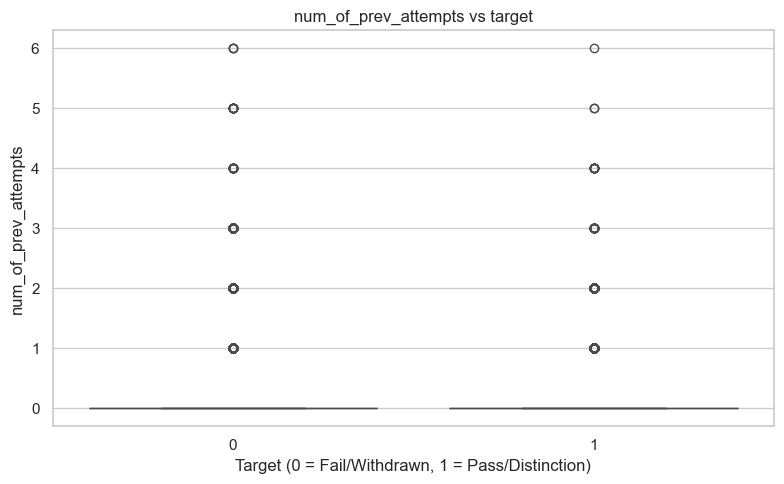

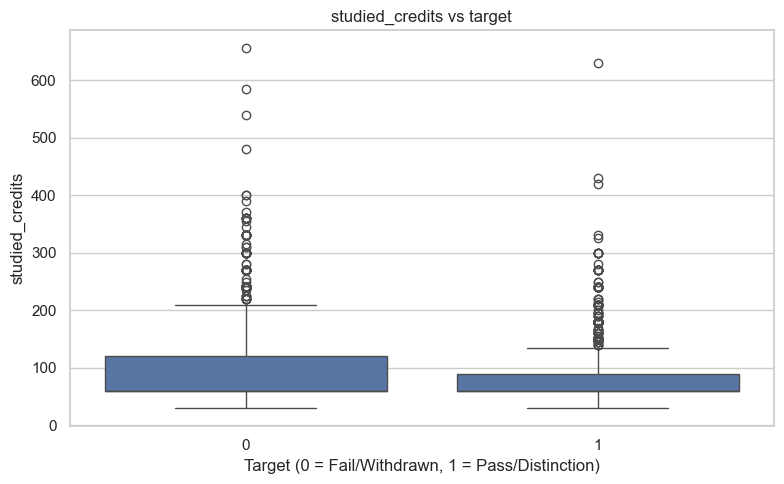

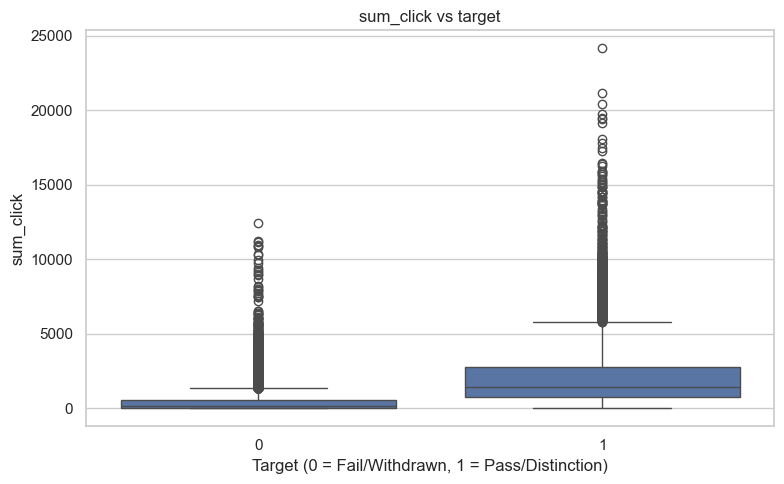

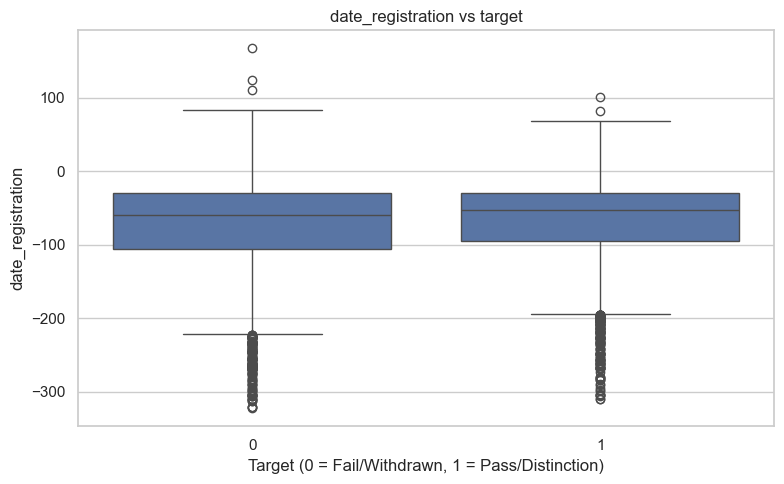

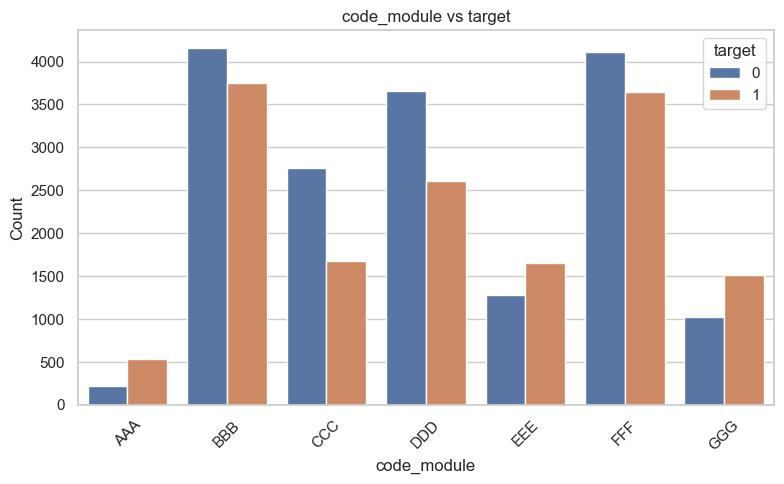

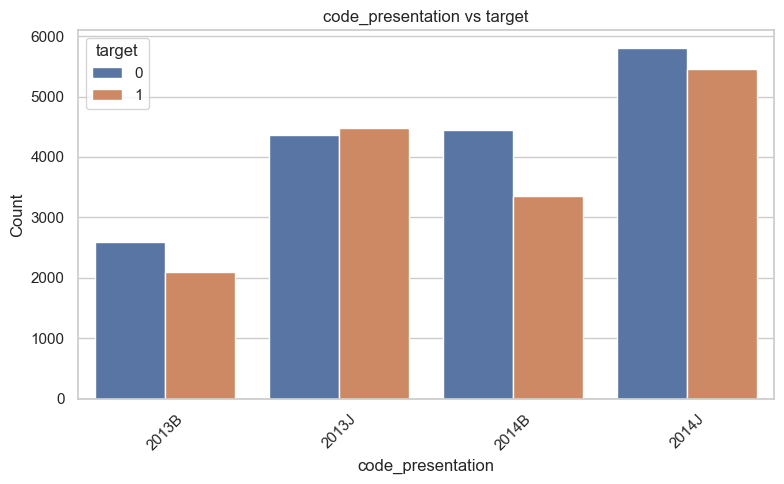

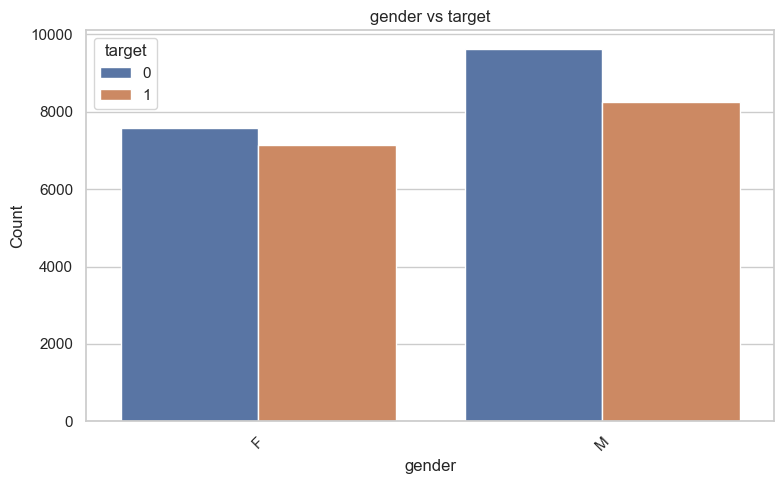

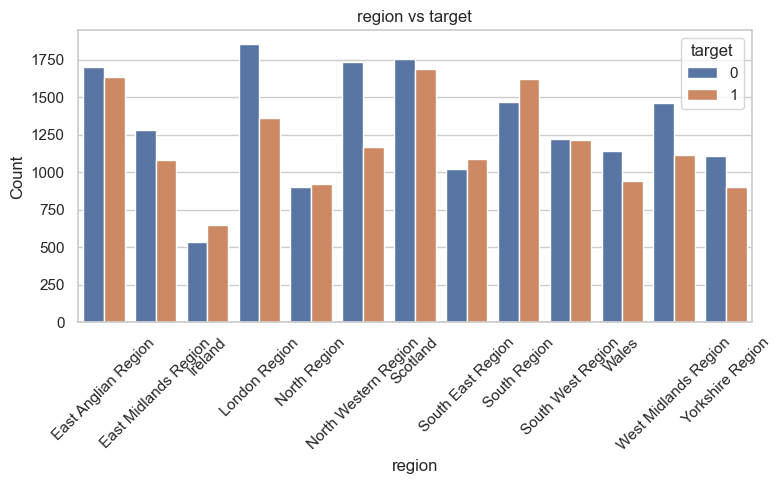

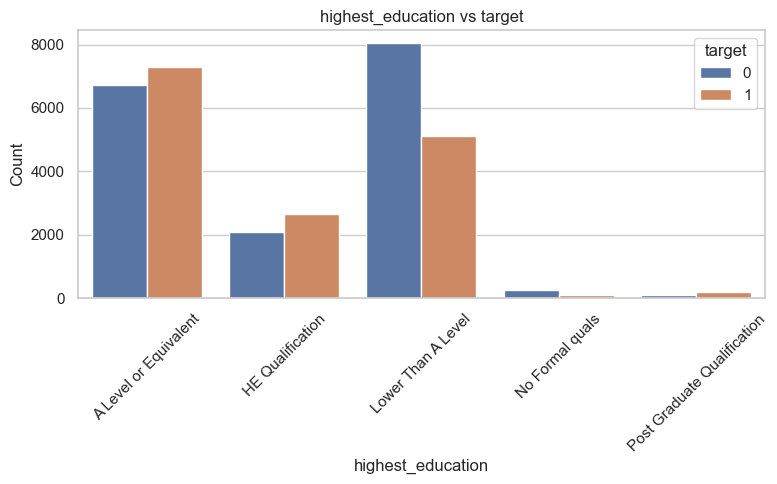

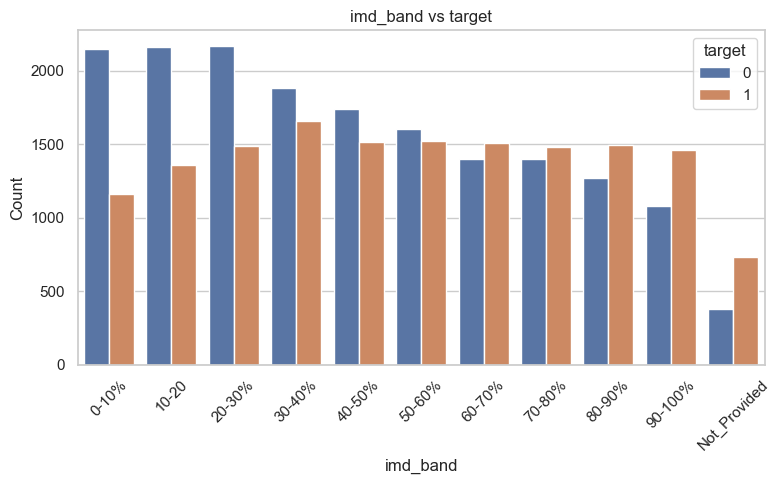

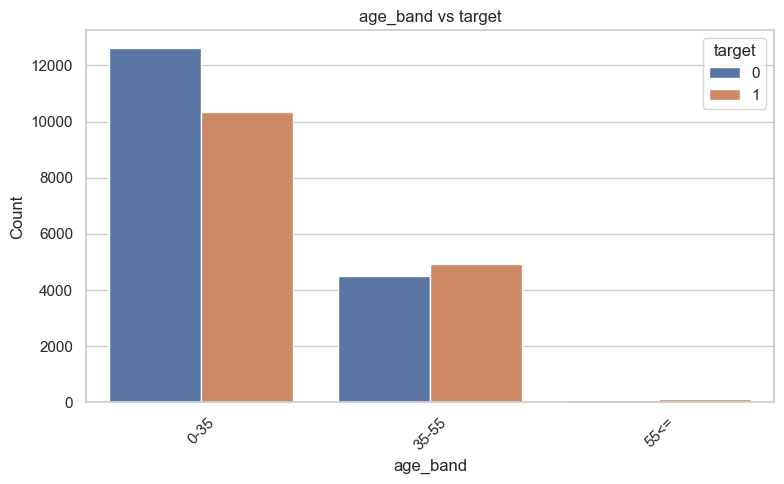

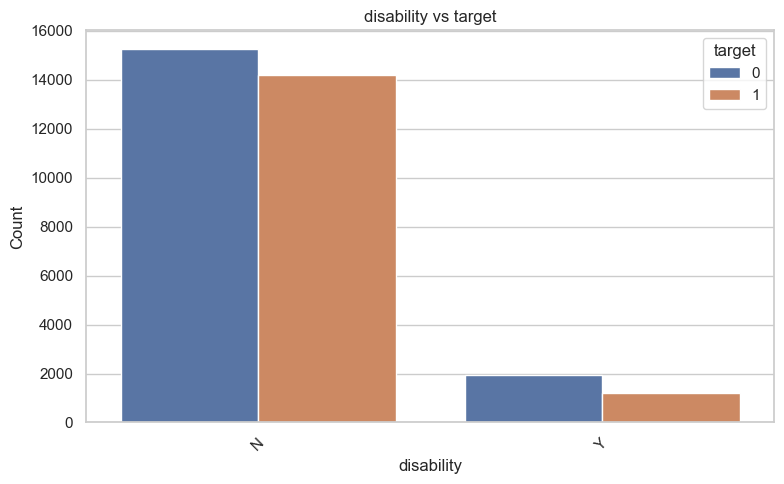

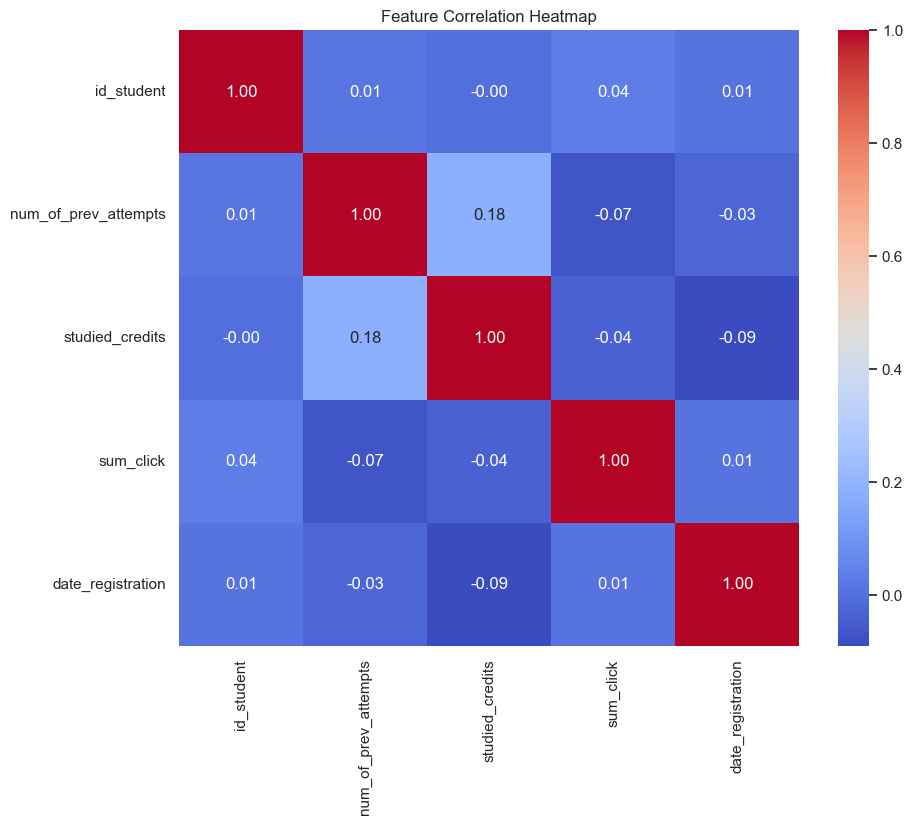

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# -----------------------------------------
# Function for numeric feature vs target (e.g., sum_click)
# Shows a boxplot to compare distribution by class
# -----------------------------------------
def plot_numeric_vs_target(df, numeric_col, target_col='target'):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=target_col, y=numeric_col, data=df)
    plt.title(f"{numeric_col} vs {target_col}")
    plt.xlabel("Target (0 = Fail/Withdrawn, 1 = Pass/Distinction)")
    plt.ylabel(numeric_col)
    plt.tight_layout()
    plt.show()

# -----------------------------------------
# Function for categorical feature vs target
# Shows a countplot (grouped bar chart)
# -----------------------------------------
def plot_categorical_vs_target(df, cat_col, target_col='target'):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=cat_col, hue=target_col, data=df,
                  order=sorted(df[cat_col].dropna().unique()))
    plt.title(f"{cat_col} vs {target_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    plt.legend(title=target_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if col != 'target' and col != 'id_student':  
        plot_numeric_vs_target(df, col)

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if col != 'final_result': 
        plot_categorical_vs_target(df, col)

numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=['target'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import time

# Separate target from df
X = df.drop(columns=['target', 'code_module', 'code_presentation', 'id_student', 'final_result'])
y = df['target']

X = pd.get_dummies(X)  # one-hot encoding for catogorical columns
print(X.columns.tolist())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split train/test to 80/20 and stratify for average distribution of labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'DecisionTree': Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value=0)), # Use pipeline to avoid Nah error in SVM
        ('model', DecisionTreeClassifier())
    ]),
    'RandomForest': Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
        ('model', RandomForestClassifier())
    ]),
    'SVM': Pipeline([
        ('imputer', SimpleImputer(strategy="constant", fill_value=0)),
        ('model', SVC(kernel='linear', probability=True))  # Use linear kernel to get feature importance; Output predictability
    ]),
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)  # K fold 5 times


best_model = None
best_score = 0
best_model_name = ""
model_scores = []

for name, model in models.items():
    print(f"\nTraining {name.upper()}...")
    start_time = time.time()

    fold_metrics = []

    for train_index, val_index in kf.split(X_train):
        print(f"Training fold with train_index size: {len(train_index)}, val_index size: {len(val_index)}")
        X_ktrain, X_kval = X_train[train_index], X_train[val_index]
        y_ktrain, y_kval = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_ktrain, y_ktrain)
        if name in ['DecisionTree', 'RandomForest']:
            # Check feature_importances_
            dt = model.named_steps['model']
            importances = dt.feature_importances_
            feat_importances = pd.Series(importances, index=X.columns)
            feat_importances = feat_importances.sort_values(ascending=False)
            print(f"Top 5 important features for {name}:")
            print(feat_importances.head(10))
        
        elif name == 'SVM':
            # Use coef_ to find features with higher abs value
            dt = model.named_steps['model']
            coef = dt.coef_[0]
            feat_importances = pd.Series(abs(coef), index=X.columns)
            feat_importances = feat_importances.sort_values(ascending=False)
            print(f"Top 5 important features for {name} (based on absolute coefficient values):")
            print(feat_importances.head(10))
            
        y_pred = model.predict(X_kval)
        y_prob = model.predict_proba(X_kval)[:, 1] if hasattr(
            model, "predict_proba") else None

        acc = accuracy_score(y_kval, y_pred)
        prec = precision_score(y_kval, y_pred, zero_division=0)
        rec = recall_score(y_kval, y_pred)
        f1 = f1_score(y_kval, y_pred)
        auc = roc_auc_score(y_kval, y_prob) if y_prob is not None else 0

        fold_metrics.append((acc, prec, rec, f1, auc))
        print(f"Avg Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    avg_scores = np.mean(fold_metrics, axis=0)
    elapsed_time = time.time() - start_time
    print(f"Training time for {name}: {elapsed_time:.2f} seconds")

    # Run models with test data
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, zero_division=0)
    test_rec = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else 0

    # Evaluate the best model with test splits
    model_scores.append({
        'name': name,
        'model': model,
        'train_time': elapsed_time,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'test_auc': test_auc
    })
   
# Save top3 models with higher auc and F1 to avoid overfitting
top_models = sorted(model_scores, key=lambda x: 0.5 * x['test_f1'] + 0.5 * x['test_auc'], reverse=True)[:3] 

for i, entry in enumerate(top_models, 1):
    filename = f"../models/top{i}_{entry['name']}.pkl"
    joblib.dump(entry['model'], filename, compress=5)
    print(f"Saved: {filename} | F1: {entry['test_f1']:.4f}, AUC: {entry['test_auc']:.4f}, Time: {entry['train_time']:.2f}s")

['num_of_prev_attempts', 'studied_credits', 'sum_click', 'date_registration', 'gender_F', 'gender_M', 'region_East Anglian Region', 'region_East Midlands Region', 'region_Ireland', 'region_London Region', 'region_North Region', 'region_North Western Region', 'region_Scotland', 'region_South East Region', 'region_South Region', 'region_South West Region', 'region_Wales', 'region_West Midlands Region', 'region_Yorkshire Region', 'highest_education_A Level or Equivalent', 'highest_education_HE Qualification', 'highest_education_Lower Than A Level', 'highest_education_No Formal quals', 'highest_education_Post Graduate Qualification', 'imd_band_0-10%', 'imd_band_10-20', 'imd_band_20-30%', 'imd_band_30-40%', 'imd_band_40-50%', 'imd_band_50-60%', 'imd_band_60-70%', 'imd_band_70-80%', 'imd_band_80-90%', 'imd_band_90-100%', 'imd_band_Not_Provided', 'age_band_0-35', 'age_band_35-55', 'age_band_55<=', 'disability_N', 'disability_Y']

Training DECISIONTREE...
Training fold with train_index size: 2

KeyboardInterrupt: 

In [7]:
scores_df = pd.DataFrame(model_scores)

# Drop the actual model objects 
if 'model' in scores_df.columns:
    scores_df = scores_df.drop(columns=['model'])

print("\nFinal Evaluation Scores for All Models:\n")
for _, row in scores_df.iterrows():
    print(" | ".join([f"{col}: {row[col]:.4f}" if isinstance(row[col], float) else f"{col}: {row[col]}" for col in scores_df.columns]))


Final Evaluation Scores for All Models:

name: DecisionTree | train_time: 0.7151 | test_accuracy: 0.7497 | test_precision: 0.7370 | test_recall: 0.7303 | test_f1: 0.7336 | test_auc: 0.7486
name: RandomForest | train_time: 10.3999 | test_accuracy: 0.8029 | test_precision: 0.7747 | test_recall: 0.8213 | test_f1: 0.7973 | test_auc: 0.8856
name: SVM | train_time: 460.2993 | test_accuracy: 0.7946 | test_precision: 0.8294 | test_recall: 0.7111 | test_f1: 0.7657 | test_auc: 0.8855
